In [1]:
import sifce
import pandas as pd
import numpy as np
from bilby.core.prior import Uniform, Sine, Cosine, PowerLaw, Constraint, DeltaFunction
from pycbc.detector import Detector
from bilby.core.prior import PriorDict
from pycbc.psd import analytical

In [2]:
# get ifos
ifos=['H1', 'L1', 'V1']
ifos_det = dict()

for ifo in ifos:
    ifos_det[ifo] = Detector(ifo)

In [3]:
from sifce import population
from sifce import datatools

# samples for generating waves
prior = dict(mass_1= DeltaFunction(35),
             mass_2= DeltaFunction(35),
             a_1 = DeltaFunction(0.5),
             a_2 = DeltaFunction(0.5),
             tilt_1 = DeltaFunction(1.4),
             tilt_2 = DeltaFunction(1.4),
             phi_12 = DeltaFunction(3.09),
             phi_jl = DeltaFunction(5.21),
             theta_jn =  Sine(name='theta_jn'),
             phase = DeltaFunction(1.04),
             reference_frequency = DeltaFunction(20))
prior_obj = PriorDict(dictionary = prior)
pop = population.SimulationSet(distribution=prior_obj)
pop.sample_distribution(100)

In [4]:
# sky samples
prior_sky = dict(dec=Cosine(name='dec'),
                ra=Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic'),
                psi =  Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic'),)
prior_sky_obj = PriorDict(dictionary = prior_sky)
sky_pop = prior_sky_obj.sample(1000)

In [5]:
# set psd
sample_rate=1024
flow = 20.0
delta_f = 1.0/8
flen = int(sample_rate/delta_f)
psd = analytical.aLIGOZeroDetHighPower(flen, delta_f, flow)

psd_dict = {'H1': psd, 'L1': psd, 'V1':psd}
apx='IMRPhenomXPHM'

In [6]:
# calculate snr
sky_catter_results_list = list()

temp_pd = pop.simulations_dataframe

for index, row in temp_pd.iterrows():
    tmp_dict = row.to_dict()
    
    # get hp and hc:
    param_args = { k: tmp_dict[k] for k in pop.waveform_generation_labels}
    strain = dict()
    strain['plus'], strain['cross'] = datatools.compute_hphc_fd(param_args, apx)
        
    #sky scatter:
    opt_snr_arrays = datatools.sky_scatter_snr(sky_pop, {'plus_template': strain['plus'], 'cross_template': strain['cross']}, 0, psd_dict, ifo_list=ifos)
    sky_catter_results_list.append(opt_snr_arrays)
    

/home/daniela.yano/summer-2022/sifce/sifce/datatools.py:410: RuntimeWarning: overflow encountered in square
  rho_mf_net += rho_mf_array**2
/home/daniela.yano/summer-2022/sifce/sifce/datatools.py:408: RuntimeWarning: overflow encountered in square
  rho_mf_net = rho_mf_array**2


In [16]:
# need to rearange dataframe
df= pop.simulations_dataframe
df= pd.concat(1000*[df])
df= df.sort_index(ascending=True)
df=df.reset_index()

In [17]:
df_sky=pd.DataFrame(sky_pop)
df_sky=pd.concat(100*[df_sky])
df_sky=df_sky.reset_index()

In [18]:
df['ra']=df_sky['ra']
df['dec']=df_sky['dec']
df['psi']=df_sky['psi']

In [19]:
# add opt_snr
tmp_snr_network_list = list()
for snr_tuple in sky_catter_results_list:
    tmp_snr_network_list.extend(snr_tuple[0]['net'])

In [20]:
df['opt_snr'] = tmp_snr_network_list

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   index                 100000 non-null  int64  
 1   mass_1                100000 non-null  float64
 2   mass_2                100000 non-null  float64
 3   spin_1x               100000 non-null  float64
 4   spin_1y               100000 non-null  float64
 5   spin_1z               100000 non-null  float64
 6   spin_2x               100000 non-null  float64
 7   spin_2y               100000 non-null  float64
 8   spin_2z               100000 non-null  float64
 9   theta_jn              100000 non-null  float64
 10  phase                 100000 non-null  float64
 11  ra                    100000 non-null  float64
 12  dec                   100000 non-null  float64
 13  psi                   100000 non-null  float64
 14  geocent_time          0 non-null       object 
 15  l

In [22]:
# now I need to generate luminosity distance
prior_ldistance = dict(luminosity_distance = PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$'))
prior_ldistanex_obj = PriorDict(dictionary = prior_ldistance)
lum_distribution = prior_ldistanex_obj.sample(10)

In [23]:
# do scaling and update opt_snr
df_ld=pd.DataFrame(lum_distribution)
df_ld=pd.concat(100000*[df_ld])
df_ld=df_ld.reset_index()

In [24]:
# need to clone df rows first
new_df= pd.concat(10*[df])
new_df= new_df.sort_index(ascending=True)
new_df= new_df.reset_index()

In [25]:
# let's check dimensions
print(len(new_df))
print(len(df_ld))

1000000
1000000


In [26]:
new_df['opt_snr']= new_df['opt_snr']/df_ld['luminosity_distance']
new_df['luminosity_distance']=df_ld['luminosity_distance']

In [27]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 39 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   level_0               1000000 non-null  int64  
 1   index                 1000000 non-null  int64  
 2   mass_1                1000000 non-null  float64
 3   mass_2                1000000 non-null  float64
 4   spin_1x               1000000 non-null  float64
 5   spin_1y               1000000 non-null  float64
 6   spin_1z               1000000 non-null  float64
 7   spin_2x               1000000 non-null  float64
 8   spin_2y               1000000 non-null  float64
 9   spin_2z               1000000 non-null  float64
 10  theta_jn              1000000 non-null  float64
 11  phase                 1000000 non-null  float64
 12  ra                    1000000 non-null  float64
 13  dec                   1000000 non-null  float64
 14  psi                   1000000 non-n

In [28]:
# filter opt_snt > 11 
df_final = new_df[new_df['opt_snr']>=11]

In [30]:
pd.set_option('display.max_columns', None)
df_final

,level_0,index,mass_1,mass_2,spin_1x,spin_1y,spin_1z,spin_2x,spin_2y,spin_2z,theta_jn,phase,ra,dec,psi,geocent_time,luminosity_distance,redshift,chirp_mass,total_mass,mass_ratio,symmetric_mass_ratio,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,reference_frequency,cal_idx,opt_snr,template_snr,iota,phi_1,phi_2
0,0,0,35.0,35.0,0.429093,-0.242193,0.084984,-0.416032,0.263999,0.084984,2.323959,1.04,1.461919,1.291181,2.361421,NaN,1807.324959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,1.4,1.4,3.09,5.21,20.0,NaN,20.520691,NaN,2.329290,5.769331,2.576145
1,0,0,35.0,35.0,0.429093,-0.242193,0.084984,-0.416032,0.263999,0.084984,2.323959,1.04,1.461919,1.291181,2.361421,NaN,1502.492216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,1.4,1.4,3.09,5.21,20.0,NaN,24.684026,NaN,2.329290,5.769331,2.576145
2,0,0,35.0,35.0,0.429093,-0.242193,0.084984,-0.416032,0.263999,0.084984,2.323959,1.04,1.461919,1.291181,2.361421,NaN,284.230359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,1.4,1.4,3.09,5.21,20.0,NaN,130.484148,NaN,2.329290,5.769331,2.576145
3,0,0,35.0,35.0,0.429093,-0.242193,0.084984,-0.416032,0.263999,0.084984,2.323959,1.04,1.461919,1.291181,2.361421,NaN,1136.717118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,1.4,1.4,3.09,5.21,20.0,NaN,32.626900,NaN,2.329290,5.769331,2.576145
4,0,0,35.0,35.0,0.429093,-0.242193,0.084984,-0.416032,0.263999,0.084984,2.323959,1.04,1.461919,1.291181,2.361421,NaN,1528.750904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,1.4,1.4,3.09,5.21,20.0,NaN,24.260039,NaN,2.329290,5.769331,2.576145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,99999,99,35.0,35.0,0.427553,-0.244900,0.084984,-0.414355,0.266623,0.084984,0.675781,1.04,4.416853,0.749722,1.897347,NaN,1332.723098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,1.4,1.4,3.09,5.21,20.0,NaN,20.792236,NaN,0.681121,5.763010,2.569824
999996,99999,99,35.0,35.0,0.427553,-0.244900,0.084984,-0.414355,0.266623,0.084984,0.675781,1.04,4.416853,0.749722,1.897347,NaN,1815.387143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,1.4,1.4,3.09,5.21,20.0,NaN,15.264123,NaN,0.681121,5.763010,2.569824
999997,99999,99,35.0,35.0,0.427553,-0.244900,0.084984,-0.414355,0.266623,0.084984,0.675781,1.04,4.416853,0.749722,1.897347,NaN,927.752055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,1.4,1.4,3.09,5.21,20.0,NaN,29.868210,NaN,0.681121,5.763010,2.569824
999998,99999,99,35.0,35.0,0.427553,-0.244900,0.084984,-0.414355,0.266623,0.084984,0.675781,1.04,4.416853,0.749722,1.897347,NaN,1601.608568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,1.4,1.4,3.09,5.21,20.0,NaN,17.301539,NaN,0.681121,5.763010,2.569824


In [33]:
max_distance = np.max(df_final['luminosity_distance'])
max_distance

1815.3871433823772

In [88]:
from scipy import interpolate
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u

In [143]:
ld_list = lum_distribution['luminosity_distance']
ld_list = np.append(ld_list, 1)

z_lst = list()
for i in ld_list:
    z_lst.append(z_at_value(Planck18.luminosity_distance, i*u.Mpc).value)

In [144]:
# get function with interpolate
cosmo_lst = list()
for z in z_lst:
    e = Planck18.efunc(z)
    cosmo_lst.append(1/(e*(1+z)**3))

kernel = np.array(cosmo_lst) * np.square(ld_list)
f = interpolate.interp1d(z_lst, kernel)

In [145]:
z_lst

[0.33289384439292957,
 0.28363006501654386,
 0.06132874531836988,
 0.22181875836569234,
 0.28794787843838837,
 0.25534381033596204,
 0.33417254896072945,
 0.18491347623232812,
 0.2998519935028955,
 0.30189651145920565,
 0.00022565044051694265]

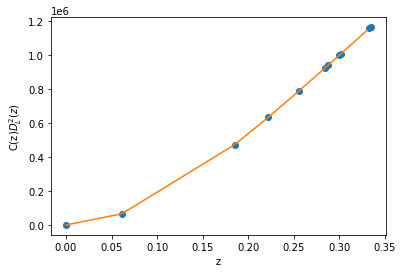

In [146]:
# plot function to check!
import matplotlib.pyplot as plt
xnew = np.arange(np.min(z_lst), np.max(z_lst), 0.01)
ynew = f(xnew)   # use interpolation function returned by `interp1d`

plt.ylabel("C(z)$D_L^2(z)$")
plt.xlabel("z")
plt.plot(z_lst, kernel, 'o')
plt.plot(xnew, ynew, '-')

plt.show()

In [147]:
# now we can integrate!
from scipy import integrate
z_max = np.max(z_lst)
# integrating from min z because of f --> need to integrate from 0? (need to have DL(0) in the list and then use interpolate)
integral = integrate.quad(f, np.min(z_lst), z_max)

In [148]:
s = df_final['luminosity_distance'].value_counts()    

In [149]:
s

284.230359     99966
927.752055     96852
1136.717118    93550
1332.723098    88807
1502.492216    83691
1528.750904    82908
1601.608568    80398
1614.189639    79942
1807.324959    72719
1815.387143    72390
Name: luminosity_distance, dtype: int64

In [153]:
from astropy import constants as cons
total_sum = 0
for d, n in s.items():
    z = z_at_value(Planck18.luminosity_distance, d*u.Mpc).value
    total_sum += n*integrate.quad(f, np.min(z_lst), z)[0]

n = 1e6
total_sum = total_sum  * u.Mpc ** 2
h0 = Planck18.H(0)
volume_sens = (1*u.year)*(const.c/h0)*4*np.pi*total_sum/n

/tmp/ipykernel_600962/3251613121.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  total_sum += n*integrate.quad(f, np.min(z_lst), z)[0]


In [154]:
volume_sens 

<Quantity 4.18541151e+12 m Mpc3 yr / km>

In [155]:
volume_sens * (u.km / (1e3 * u.m)) * (u.Gpc**3/(1e9*u.Mpc**3))

<Quantity 4.18541151 Gpc3 yr>